### As a customer analyst, I want to know who has spent the most money with us over their lifetime. I have monthly charges and tenure, so I think I will be able to use those two attributes as features to estimate total_charges. I need to do this within an average of $5.00 per customer.

In [119]:
import pandas as pd
import sklearn.preprocessing
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from wrangle import wrangle_telco
from split_scale import split_my_data, standard_scaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, QuantileTransformer, PowerTransformer, MinMaxScaler, RobustScaler
from sklearn.linear_model import LinearRegression

### ACQUIRE & PREPROCESS

#### Study the Data

In [17]:
telco = wrangle_telco()

telco.head()
telco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 0 to 1684
Data columns (total 5 columns):
customer_id        1685 non-null object
monthly_charges    1685 non-null float64
tenure             1685 non-null int64
multiple_lines     1685 non-null object
total_charges      1685 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 79.0+ KB


ValueError: color kwarg must have one color per data set. 1685 data sets and 1 colors were provided

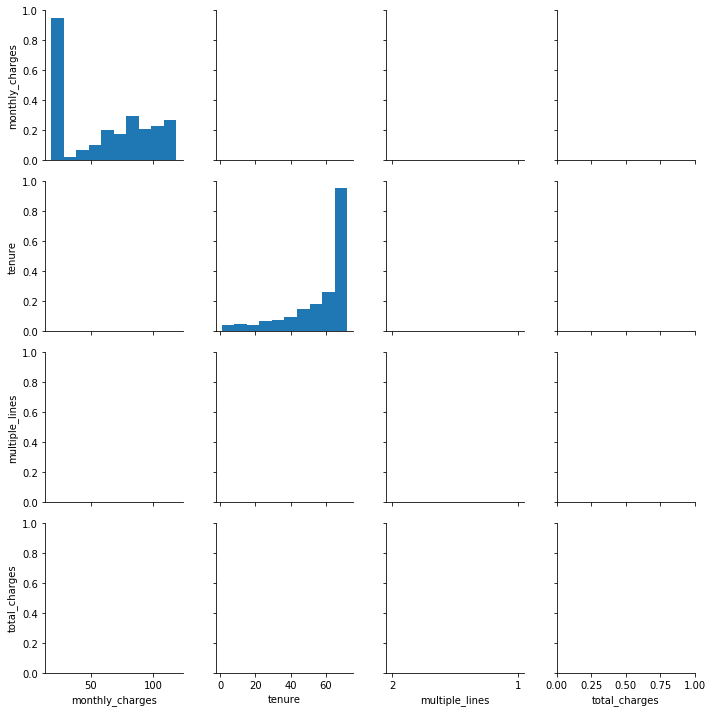

In [120]:
sns.pairplot(telco)

#### Clean the Data

Multiple Lines variable is categorical with Yes, No, or No phone service as values. We want to change the values such that:
- Yes = 2
- No = 1
- No phone service = 0


In [46]:
telco.multiple_lines = telco.multiple_lines.str.replace("Yes","2")
telco.multiple_lines = telco.multiple_lines.str.replace("No","1")
telco.multiple_lines = telco.multiple_lines.str.replace("1 phone service","0")

159

In [49]:
telco.multiple_lines.astype(int)
telco.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 0 to 1684
Data columns (total 5 columns):
customer_id        1685 non-null object
monthly_charges    1685 non-null float64
tenure             1685 non-null int64
multiple_lines     1685 non-null object
total_charges      1685 non-null float64
dtypes: float64(2), int64(1), object(2)
memory usage: 79.0+ KB


#### Split Data to test and train, x and y

In [121]:
X = telco[["monthly_charges", "tenure", "multiple_lines"]]
y = telco.total_charges

X_train, X_test, y_train, y_test = split_my_data(X, y, 0.8)

#### Scale X variables

I'm using Standard Scaler to scale the independent variables, monthly charges and tenure, which are in different scales, and units. Monthly charges are measured in dollars and tenure is measured in years.

In [122]:
X_train, X_test, scaler = standard_scaler(X_train, X_test)

In [123]:
X_train
X_test

,monthly_charges,tenure,multiple_lines
304,1.431268,0.432473,0.870194
450,0.899592,0.659886,0.870194
909,0.036163,0.603032,-0.637546
1411,-1.054714,0.205060,0.870194
1547,-1.208276,0.489326,-0.637546
103,-1.195238,-1.045712,-0.637546
167,1.341448,0.830445,0.870194
1463,-1.202482,0.773592,-0.637546
1192,-0.040619,-0.818299,-0.637546
1441,-1.073547,0.034500,0.870194


#### Feature Engineering

Correlation threshold to see which variables are worth pursuing.

_**Note:** I re-combined the train partitions of scaled X with y again because I split the data into 4 data frames in the split-train-test phase. However, I need them again to see correlations between X and y, only this time I want to run JUST the train data._

In [124]:
train_combined = X_train.copy()
train_combined["total_charges"] = y_train
train_combined.head()

,monthly_charges,tenure,multiple_lines,total_charges
119,1.506600,0.830445,0.870194,8164.10
1414,-1.173508,0.773592,-0.637546,1493.20
384,1.274807,0.375619,0.870194,6794.75
1131,-0.044965,-0.306619,0.870194,3103.25
1494,-1.032983,-0.306619,0.870194,1345.85


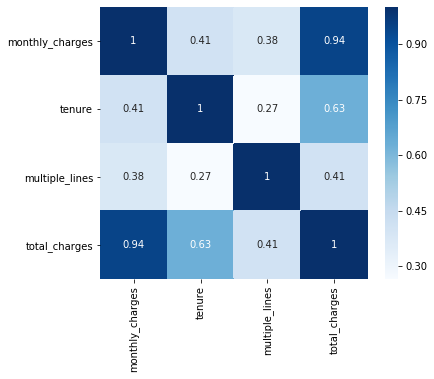

In [105]:
plt.figure(figsize=(6,5))
correlation = train_combined.corr()
sns.heatmap(correlation, annot=True, cmap=plt.cm.Blues)

**Takeaway:**  
With the R values below, we will explore the two variables with highest correlation with the Total Charges, that is, Monthly Charges and Tenure.

Pearsons R values  
- total_charges | monthly_charges = 0.94  
- total_charges | tenure = 0.63
- total_charges | multiple_lines = 0.41

### MODEL

In [129]:
X_train.head()
# y_train.head()

,monthly_charges,tenure,multiple_lines
119,1.506600,0.830445,0.870194
1414,-1.173508,0.773592,-0.637546
384,1.274807,0.375619,0.870194
1131,-0.044965,-0.306619,0.870194
1494,-1.032983,-0.306619,0.870194


In [131]:
lmodel = LinearRegression().fit(X_train[["monthly_charges","tenure"]],y_train)
intercept = lmodel.intercept_
coefficients = lmodel.coef_

In [127]:
print("Train data's intercept: ", intercept)
print("Train data's coefficients: ", coefficients)

Train data's intercept:  3770.249925816024
Train data's coefficients:  [2109.75874065  745.57518468]
